# Task 7 group:
- Raneem Alshaye
- Khaled Alqahtani
- Nawaf Aljalaud
- Abdullah Alsaedi


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

In [2]:
#Set images path
directory = "Images/"
df_label = pd.read_csv("metadata.csv")

In [3]:
df_label

,filename,label
0,dirty_2.jpg,1
1,clean_36.jpg,0
2,clean_31.jpg,0
3,dirty_69.jpg,1
4,clean_113.jpg,0
...,...,...
232,clean_83.jpg,0
233,dirty_123.jpg,1
234,dirty_76.jpg,1
235,clean_88.jpg,0


In [4]:
#Reading images
images = []
labels = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):

        filepath = os.path.join(directory,filename)
        label = int(df_label[df_label["filename"] == filename]["label"].values[0])

        image = cv2.imread(filepath)
        image = cv2.resize(image,(224,224))

        images.append(image)
        labels.append(label)

In [5]:
print("m exemples : ",np.array(images).shape)


m exemples :  (237, 224, 224, 3)


In [7]:
import cv2
import numpy as np
from skimage import exposure, util
from skimage.filters import rank
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.morphology import disk
import random

augmented_images = []
augmented_labels = []

for image, label in zip(images, labels):
    rows, cols, _ = image.shape

    # Add random brightness
    brightness_adjustment = np.random.randint(-40, 41)
    bright_img = cv2.add(image, brightness_adjustment)
    augmented_images.append(bright_img)
    augmented_labels.append(label)

    #  Resize and shift
    new_size = np.random.randint(70, 131)
    resize_img = cv2.resize(image, (new_size, new_size))
    x_shift, y_shift = np.random.randint(-30, 31, size=2)
    M_shift = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    shifted_img = cv2.warpAffine(resize_img, M_shift, (cols, rows))
    augmented_images.append(shifted_img)
    augmented_labels.append(label)

    #  Blur using average
    average_blur_img = cv2.blur(image, (5, 5))
    augmented_images.append(average_blur_img)
    augmented_labels.append(label)


    # Emboss effect
    emboss_kernel = np.array([[0,-1,-1], [1,0,-1], [1,1,0]])
    emboss_img = cv2.filter2D(image, -1, emboss_kernel)
    augmented_images.append(emboss_img)
    augmented_labels.append(label)

    # Flip horizontally
    flip_img = cv2.flip(image, 1)
    augmented_images.append(flip_img)
    augmented_labels.append(label)

    # Gaussian blur
    gaussian_blur_img = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(gaussian_blur_img)
    augmented_labels.append(label)


# Append augmented data to the original sets
images.extend(augmented_images)
labels.extend(augmented_labels)


In [8]:
from sklearn.model_selection import train_test_split
#Spliting data
images = np.array(images)
labels = np.array(labels)
X = np.array(images)
y = np.array(labels)


X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.2, random_state=42)

In [31]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=42)

In [32]:
y_train.shape

(1327,)

In [33]:
aa = pd.DataFrame(y_train)
aa.columns = ['label']

aa.value_counts()

label
1        697
0        630
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

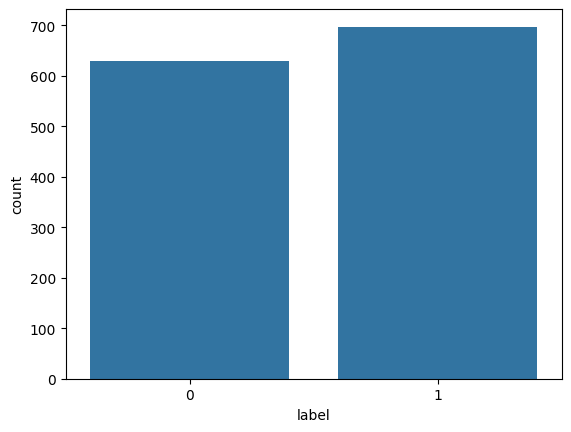

In [34]:
sns.countplot(x = 'label', data = aa)

In [35]:
#Applying normalization
X_train = X_train / 255.0
X_val =  X_val / 255.0

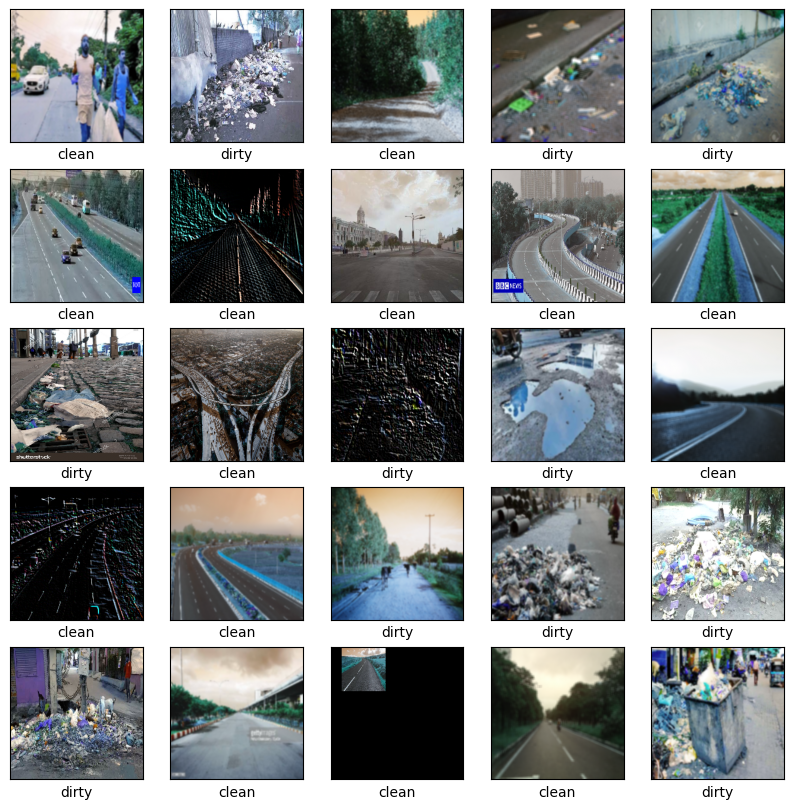

In [36]:
classes = {1:"dirty",0:"clean"}
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])
plt.show()

# Transfer Learning Implementation

In [37]:
from tensorflow.keras.applications import MobileNetV2

weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights(weights_path)
base_model.trainable = False


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [39]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
# Train the model
history = model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val))


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.7652 - loss: 2.8440 - val_accuracy: 0.9458 - val_loss: 0.2246
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 323ms/step - accuracy: 0.9799 - loss: 0.0809 - val_accuracy: 0.9578 - val_loss: 0.2079
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step - accuracy: 0.9954 - loss: 0.0086 - val_accuracy: 0.9699 - val_loss: 0.1259
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9789 - val_loss: 0.0964
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 1.0000 - loss: 4.0593e-04 - val_accuracy: 0.9789 - val_loss: 0.0949
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 1.0000 - loss: 2.9471e-04 - val_accuracy: 0.9789 - val_loss: 0.0918
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 1.0000 - loss: 2.5534e-04 - val_accuracy: 0.9759 - val_loss: 0.0966
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 341ms/step - accuracy: 1.0000 - loss: 2.222

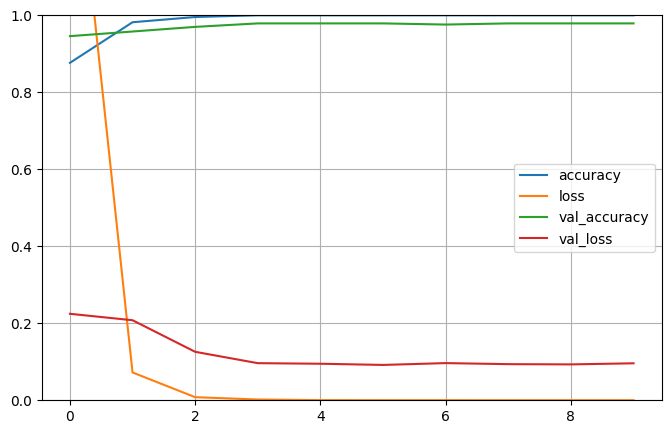

In [41]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

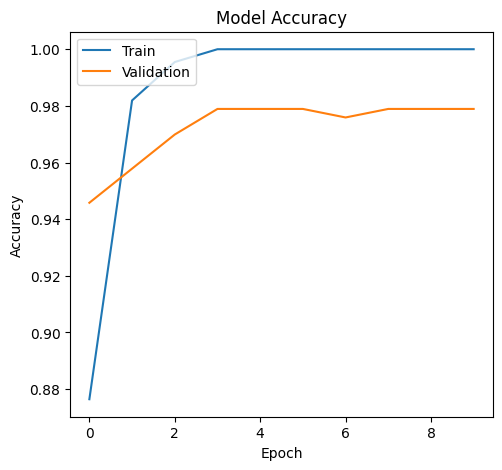

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


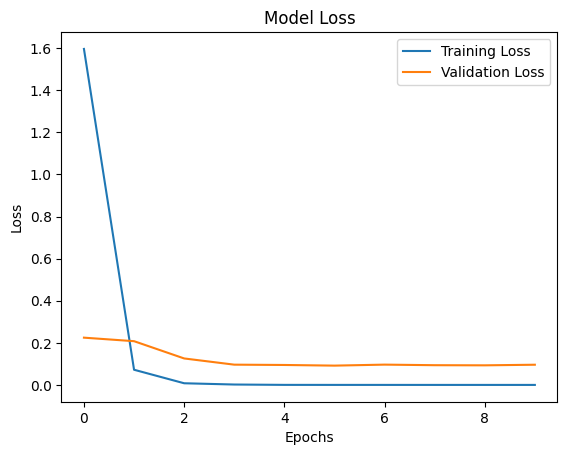

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [44]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val,y_val)
print('Validation accuracy:', val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.9843 - loss: 0.0707
Validation accuracy: 0.9789156913757324


In [45]:
img = cv2.imread('train/clean/clean_1.jpg')
img = cv2.resize(img, (224, 224))


# Normalize pixel
img = img / 255.0

# Add an extra dimension to match the batch shape
img = np.expand_dims(img, axis=0)

In [46]:
img.shape

(1, 224, 224, 3)

In [47]:
predictions = model.predict(img)
print("Predictions:", predictions)

predicted_class = (predictions > 0.5).astype('int32') # 1 or 0
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
Predictions: [[7.664878e-06]]
Predicted class: [[0]]


In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

preds = model.predict(X_val)
predictions = (preds > 0.5).astype(int)



cm = confusion_matrix(y_val, predictions)
print("Confusion Matrix:")
print(cm)

clr = classification_report(y_val, predictions, target_names=['Clean', 'Dirty'])
print("Classification Report:")
print(clr)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step
Confusion Matrix:
[[156   5]
 [  2 169]]
Classification Report:
              precision    recall  f1-score   support

       Clean       0.99      0.97      0.98       161
       Dirty       0.97      0.99      0.98       171

    accuracy                           0.98       332
   macro avg       0.98      0.98      0.98       332
weighted avg       0.98      0.98      0.98       332



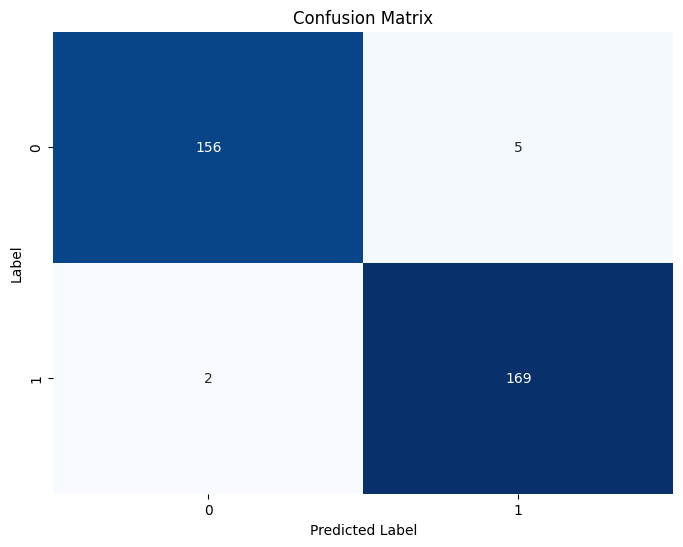

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.show()

# Training a Model from Scratch


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

scratch_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(250, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

scratch_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=8,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


In [55]:
# Train the scratch model
scratch_history = scratch_model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_val,y_val),callbacks=[early_stopping])

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 639ms/step - accuracy: 0.5336 - loss: 1.3789 - val_accuracy: 0.7199 - val_loss: 0.5330
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 673ms/step - accuracy: 0.7304 - loss: 0.5186 - val_accuracy: 0.7922 - val_loss: 0.5184
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 704ms/step - accuracy: 0.8081 - loss: 0.4322 - val_accuracy: 0.8404 - val_loss: 0.3541
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 729ms/step - accuracy: 0.8649 - loss: 0.3115 - val_accuracy: 0.8404 - val_loss: 0.3069
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 697ms/step - accuracy: 0.8825 - loss: 0.2706 - val_accuracy: 0.8886 - val_loss: 0.2427
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 739ms/step - accuracy: 0.9184 - loss: 0.1954 - val_accuracy: 0.8825 - val_loss: 0.2319
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 790ms/step - accuracy: 0.9468 - loss: 0.1470 - val_accuracy: 0.8795 - val_loss: 0.3326
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 720ms/step - accuracy: 0.9626 - loss: 0.0956 - val_accu

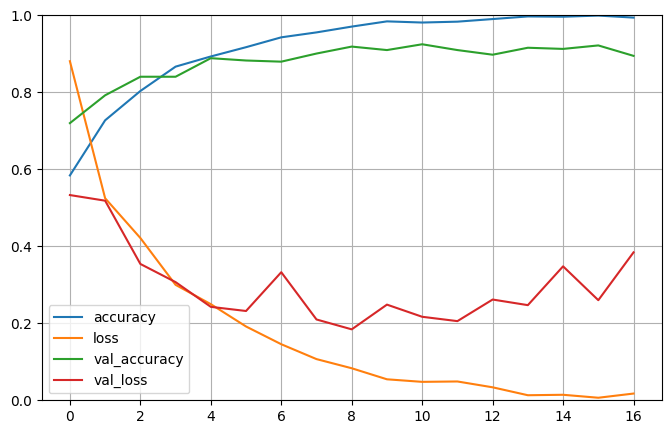

In [56]:
import matplotlib.pyplot as plt

pd.DataFrame(scratch_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

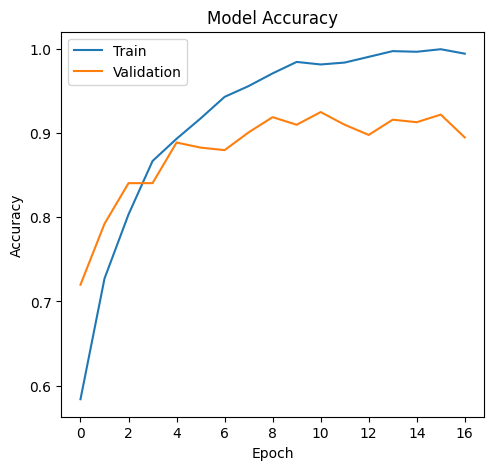

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(scratch_history.history['accuracy'])
plt.plot(scratch_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


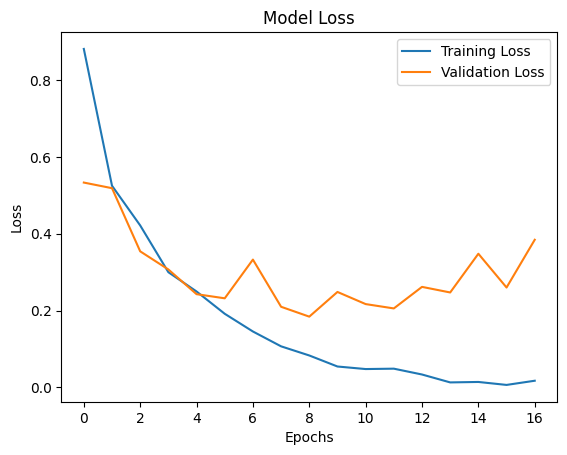

In [61]:
plt.plot(scratch_history.history['loss'], label='Training Loss')
plt.plot(scratch_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
# Evaluate the model
val_loss, val_accuracy = scratch_model.evaluate(X_val, y_val)
print('Validation accuracy:', val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9038 - loss: 0.2048
Validation accuracy: 0.9186747074127197


In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

preds = scratch_model.predict(X_val)
predictions = (preds > 0.5).astype(int)

true_classes = y_val

cm = confusion_matrix(true_classes, predictions)
print("Confusion Matrix:")
print(cm)

clr = classification_report(true_classes, predictions, target_names=['Clean', 'Dirty'])
print("Classification Report:")
print(clr)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
Confusion Matrix:
[[144  17]
 [ 10 161]]
Classification Report:
              precision    recall  f1-score   support

       Clean       0.94      0.89      0.91       161
       Dirty       0.90      0.94      0.92       171

    accuracy                           0.92       332
   macro avg       0.92      0.92      0.92       332
weighted avg       0.92      0.92      0.92       332



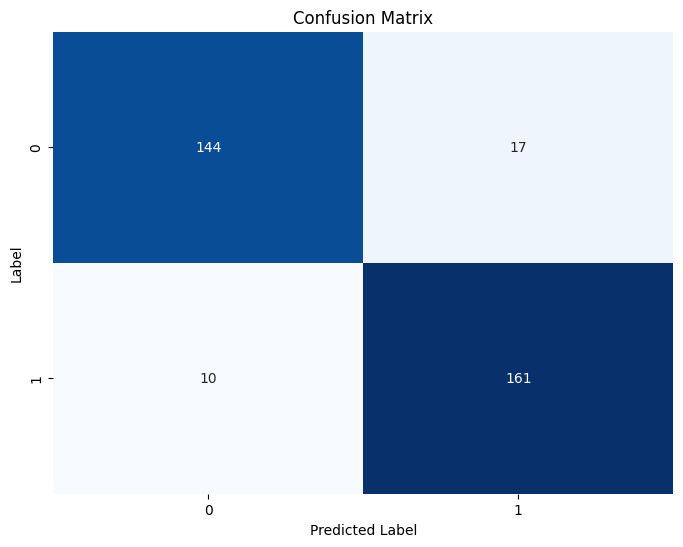

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.show()

In [65]:
predictions = scratch_model.predict(img)
print("Predictions:", predictions)

predicted_class = (predictions > 0.5).astype('int32')
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predictions: [[0.00453938]]
Predicted class: [[0]]


# Hyperparameter Tuning

In [74]:
import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
    base_model = tf.keras.Sequential()

    base_model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('filters', min_value=16, max_value=64),
        kernel_size=hp.Choice('kernel_size', values=[5, 5]),
        activation='relu',
        padding='same',
        input_shape=(224, 224, 3)))

    base_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

    base_model.add(tf.keras.layers.Flatten())

    n_hidden = hp.Int("n_hidden", min_value=0, max_value=3)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=128)
    for _ in range(n_hidden):
        base_model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    # Output layer
    base_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Learning rate tuning
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    base_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return base_model


In [75]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train,y_train, epochs=10,
                           validation_data=(X_val, y_val))

Trial 5 Complete [00h 05m 58s]
val_accuracy: 0.9066265225410461

Best val_accuracy So Far: 0.9126505851745605
Total elapsed time: 00h 20m 06s


In [84]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
filters: 18
kernel_size: 5
n_hidden: 0
n_neurons: 50
learning_rate: 0.0009749332269823054
Score: 0.9126505851745605


In [78]:
best_hp = random_search_tuner.get_best_hyperparameters()[0]

model3 = build_model(best_hp)

history3 = model3.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.5190 - loss: 1.2628 - val_accuracy: 0.7048 - val_loss: 0.6462
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.7552 - loss: 0.5963 - val_accuracy: 0.7470 - val_loss: 0.4963
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step - accuracy: 0.8511 - loss: 0.3624 - val_accuracy: 0.8434 - val_loss: 0.3779
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9360 - loss: 0.2080 - val_accuracy: 0.8584 - val_loss: 0.2935
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - accuracy: 0.9774 - loss: 0.1089 - val_accuracy: 0.8735 - val_loss: 0.2698
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.9920 - loss: 0.0640 - val_accuracy: 0.8705 - val_loss: 0.2918
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.9958 - loss: 0.0346 - val_accuracy: 0.9036 - val_loss: 0.2221
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 284ms/step - accuracy: 1.0000 - loss: 0.0253 - val_accu

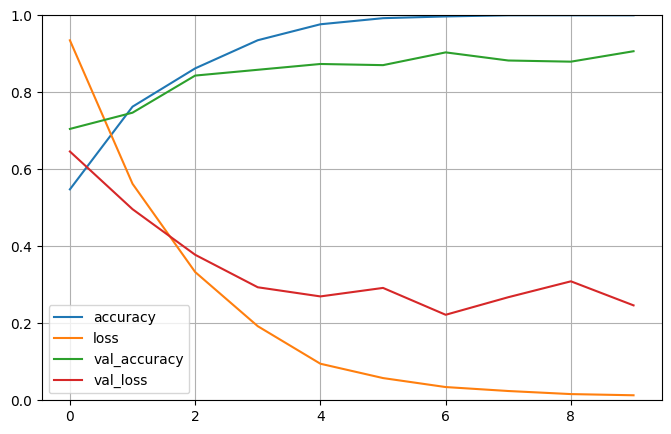

In [79]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

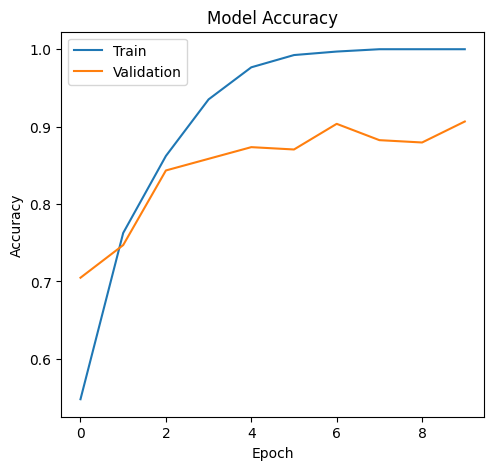

In [80]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


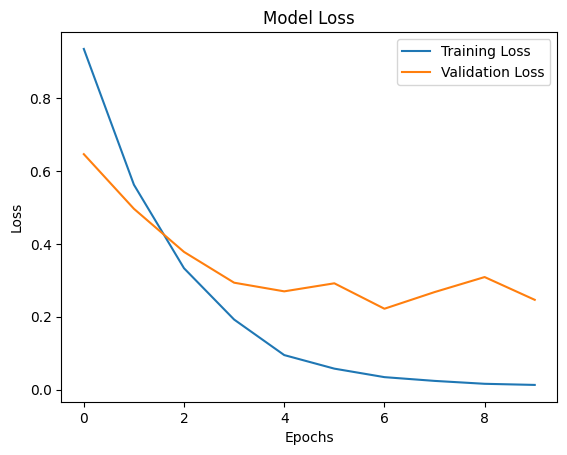

In [81]:
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

preds = model3.predict(X_val)
predictions = (preds > 0.5).astype(int)

true_classes = y_val

cm = confusion_matrix(true_classes, predictions)
print("Confusion Matrix:")
print(cm)

clr = classification_report(true_classes, predictions, target_names=['Clean', 'Dirty'])
print("Classification Report:")
print(clr)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Confusion Matrix:
[[141  20]
 [ 11 160]]
Classification Report:
              precision    recall  f1-score   support

       Clean       0.93      0.88      0.90       161
       Dirty       0.89      0.94      0.91       171

    accuracy                           0.91       332
   macro avg       0.91      0.91      0.91       332
weighted avg       0.91      0.91      0.91       332



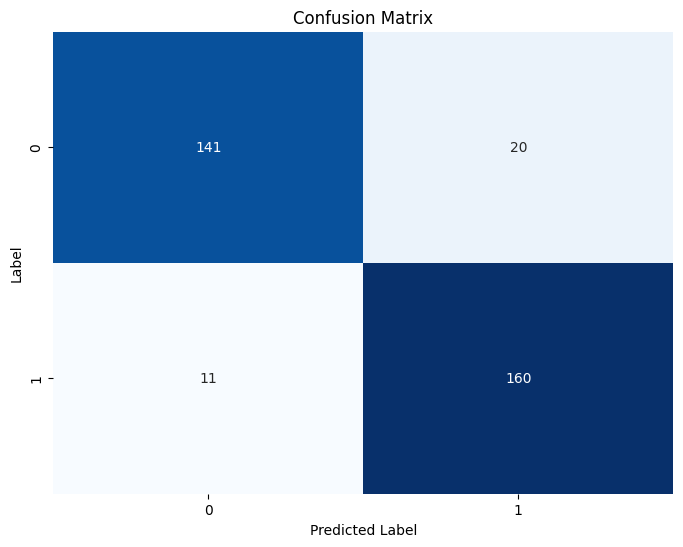

In [83]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Label')
plt.title('Confusion Matrix')
plt.show()